In [54]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pyod.models.knn import KNN
import matplotlib.pyplot as plt

## Wczytanie danych i wstępne informacje

Zaczynamy od wczytania danych z pliku csv oraz usuwamy 2 pierwsze kolumny, które są pozostałościami po podziale pliku głównego na dane treningowe i walidacyjne. Dodatkowo nasze nazwy kolumn miały pierwszą spację w nazwie, czego też się pozbywamy.

In [55]:
df = pd.read_csv('dev_train.csv')
df = df[df.columns[2:]]
df.columns = [i.strip() for i in df.columns]

Dzielimy dane na predyktory i responder.

In [56]:
Y = df[df.columns[0]]
X = df[df.columns[1:]]

Poniższe funkcje pomagają w pierwszym zapoznaniu się z danymi

In [57]:
df2 = pd.DataFrame(df.info())
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3341 entries, 0 to 3340
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                3341 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  3341 non-null   float64
 2   ROA(A) before interest and % after tax                   3341 non-null   float64
 3   ROA(B) before interest and depreciation after tax        3341 non-null   float64
 4   Operating Gross Margin                                   3341 non-null   float64
 5   Realized Sales Gross Margin                              3341 non-null   float64
 6   Operating Profit Rate                                    3341 non-null   float64
 7   Pre-tax net Interest Rate                                3341 non-null   float64
 8   After-tax net Interest Rate 

""


Funkcja .info() pokazuje, że nie mamy brakujących danych.

In [58]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,...,3341.000000,3.341000e+03,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.0,3341.000000
mean,0.036217,0.504530,0.557562,0.553026,0.607837,0.607829,0.998836,0.797131,0.808998,0.303351,...,0.807031,1.901946e+07,0.623762,0.607835,0.840195,0.280574,0.027919,0.565112,1.0,0.047988
std,0.186857,0.060516,0.065039,0.061105,0.015907,0.015894,0.006759,0.011514,0.014355,0.006779,...,0.040866,3.952391e+08,0.013940,0.015907,0.019081,0.018465,0.021371,0.015126,0.0,0.052862
min,0.000000,0.082826,0.069287,0.088388,0.156308,0.156308,0.612132,0.160516,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.156309,0.000000,0.133503,0.000000,0.000000,1.0,0.003946
25%,0.000000,0.475503,0.534562,0.526527,0.600492,0.600463,0.998969,0.797383,0.809309,0.303463,...,0.796329,9.086637e-04,0.623632,0.600492,0.840078,0.276970,0.026791,0.565158,1.0,0.024493
50%,0.000000,0.501974,0.559147,0.551636,0.606098,0.606077,0.999022,0.797463,0.809375,0.303525,...,0.810374,2.109385e-03,0.623877,0.606098,0.841119,0.278819,0.026808,0.565251,1.0,0.033593
75%,0.000000,0.536002,0.588694,0.583971,0.614004,0.614004,0.999094,0.797574,0.809467,0.303585,...,0.826023,5.345794e-03,0.624171,0.614002,0.842348,0.281449,0.026911,0.565717,1.0,0.052341
max,1.000000,1.000000,1.000000,1.000000,0.665151,0.666023,1.000000,0.807062,0.817723,0.321553,...,0.981315,9.650000e+09,1.000000,0.665149,0.996912,1.000000,1.000000,0.736985,1.0,0.920638


Boxploty dla wybranych wskaźników pomogą w zrozumieniu danych.

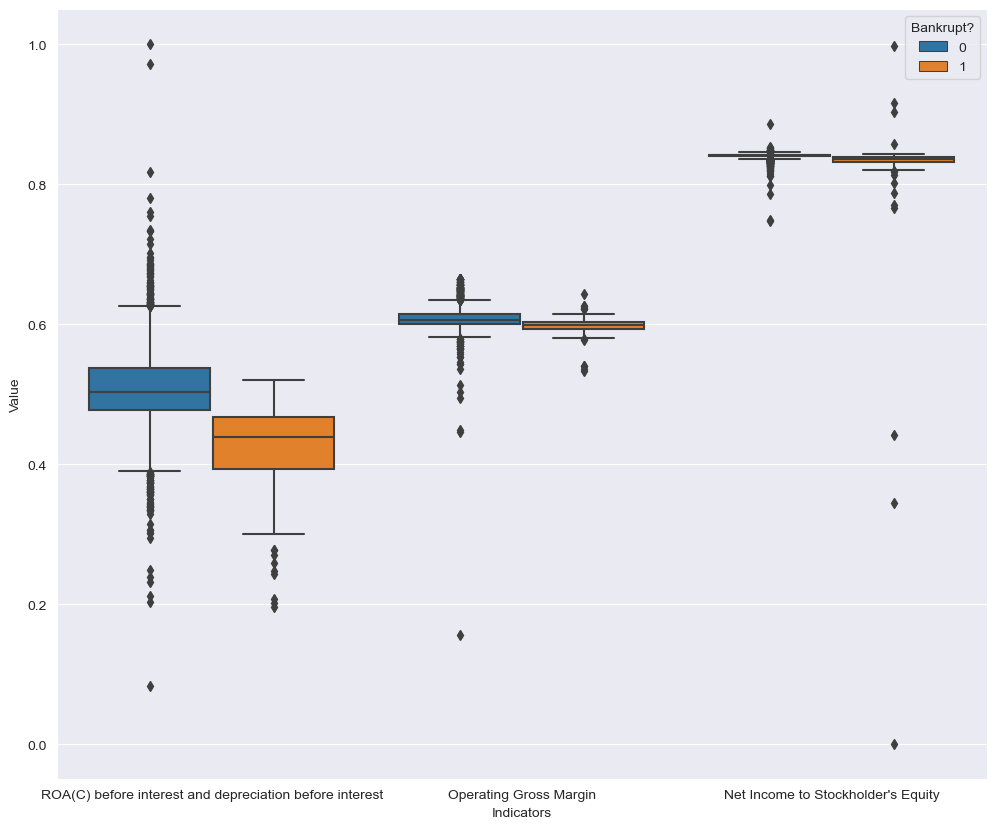

In [59]:
selected_cols = ['ROA(C) before interest and depreciation before interest', 'Operating Gross Margin', 'Net Income to Stockholder\'s Equity']
df_long = pd.melt(df, id_vars='Bankrupt?', value_vars=selected_cols, var_name='Indicators', value_name='Value')

plt.figure(figsize=(12, 10))
sns.boxplot(x='Indicators', y='Value', hue='Bankrupt?', data=df_long)
plt.savefig('wykres.png')
plt.show()


## Identyfikacja kluczowych wskaźników finansowych wpływających na upadłość firmy

Macierz korelacji pokazuje korelackje między kolejnymi wskaźnikami. Nas jednak interesuje tylko korelacja między pierwszą kolumną (Bankrupt?) a wskaźnikami.

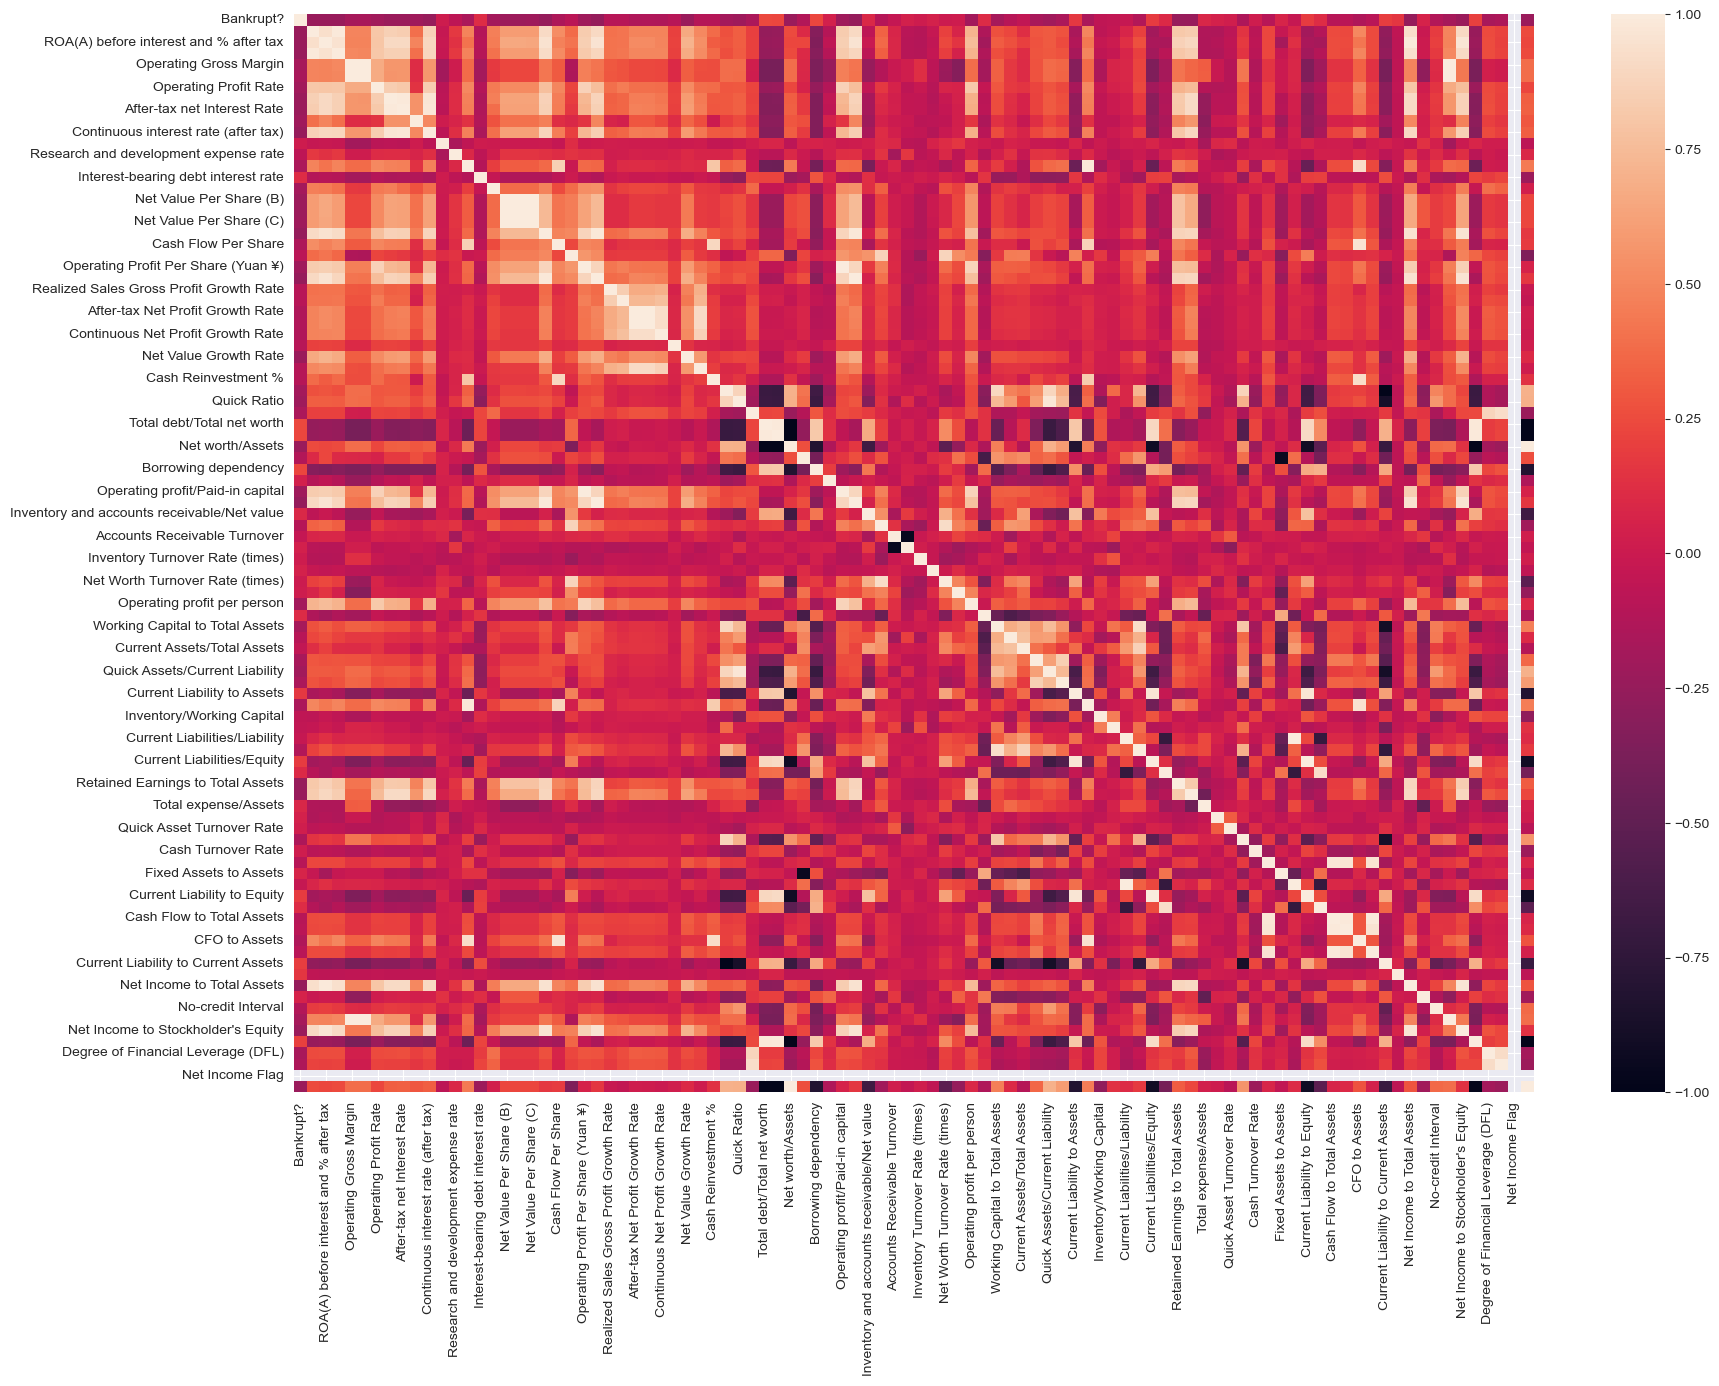

In [60]:
plt.figure(figsize=(20, 14))
sns.heatmap(df.corr(method='spearman'))
plt.savefig('corr.png')

Wybieramy pierwszą kolumnę współczynników korelacji Spearmana, sortujemy je malejąco względem wartości bezwzględnej i wybieramy pierwsze 20. Będą to wskaźniki najbardziej wpływające na to czy dana firma zbankrutowała czy nie. Korelacja na poziomie 0.25 jest bardzo wysoka, więc poniżej możemy zobaczyć, że mamy dużo dobrych wskaźników.

In [61]:
corr_df = df.corr(method='spearman')['Bankrupt?'].abs().sort_values(ascending=False).iloc[1:20]
corr_df.to_csv('corr.csv')

Plotujemy boxploty dla 3 najlepszych wskaźników. Zauważmy, że jeśli zysk netto (Net profit) jest bardzo wysoki (są to wręcz outliery) to takie firmy nigdy nie bankrutowały, natomiast jeśli ten przychód bardzo odstawał - był niski, to firma ta bankrutowała. Są to oczekiwane wnioski.

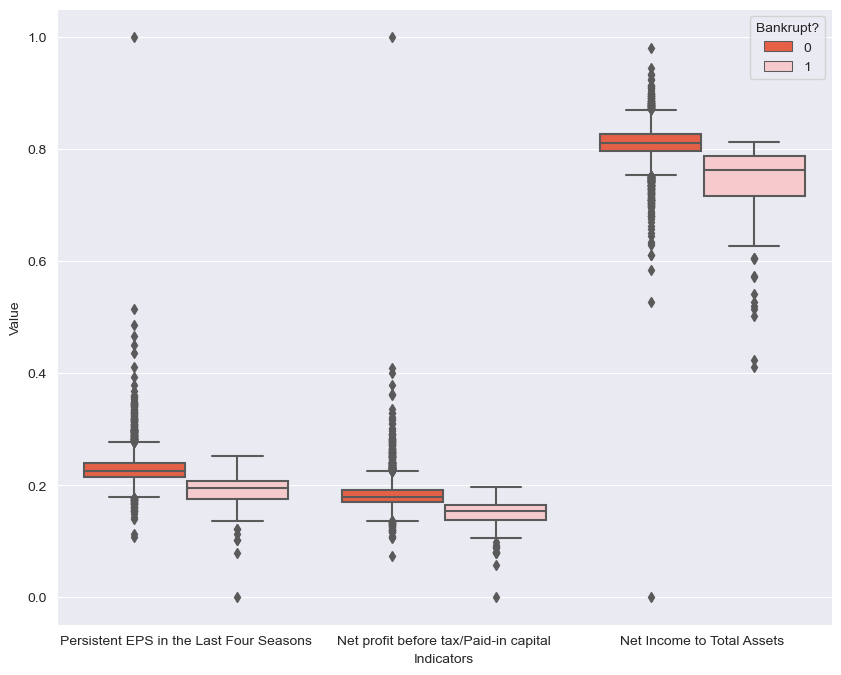

In [62]:
selected_cols = corr_df.index[:3]
df_long = pd.melt(df, id_vars='Bankrupt?', value_vars=selected_cols, var_name='Indicators', value_name='Value')

plt.figure(figsize=(10, 8))

custom_palette = {0: "#FE502D", 1: "#FDC3C5"}
sns.boxplot(x='Indicators', y='Value', hue='Bankrupt?', data=df_long, palette=custom_palette)
plt.savefig('boxplot.png')
plt.show()

## Usuwanie anomalii

Aby usunąć odstające dane, możemy skorzystać z algorytmu knn znajdowania outlierów.

In [63]:
knn = KNN(contamination=0.05, method='mean', n_neighbors=10)
knn.fit(df)
predicted = pd.Series(knn.predict(df), index=df.index)
df_outliers = df[predicted == 0]
print('Liczba outlierow = ', predicted.sum())

Liczba outlierow =  112


## Normalizacja

Coś co powinno być zrobione na początku to normalizacja danych. Jednak po dokładniejszemu przyjrzeniu się naszym danym stwierdzamy, że są one już znormalizowane (wartości są z przedziału od 0 do 1). Jednak jeśli chciuelibyśmy inaczej znormalizować dane, np. żeby były z rozkładu normalnego to zastosujemy poniższy kod.

In [64]:
X_norm = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X_norm.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1.590092,1.784798,1.921670,0.483378,0.449832,0.054893,0.080610,0.067291,0.124714,0.082836,...,1.515307,-0.048129,0.073783,0.483201,0.208196,-0.236128,-0.052763,0.003054,0.0,0.480488
1,-0.402372,-0.192739,-0.354871,-0.436031,-0.435872,0.029452,0.024815,0.023132,0.012209,0.022437,...,-0.184277,-0.048129,-0.115547,-0.435818,0.017508,0.395327,0.006118,0.184126,0.0,-0.575505
2,0.609571,0.894529,0.794791,-0.167775,-0.167394,0.034410,0.033359,0.030380,0.027222,0.031278,...,0.892134,-0.048129,0.047525,-0.167791,0.141656,-0.208214,-0.052765,0.003039,0.0,0.179846
3,-0.697253,-0.517997,-0.669451,-0.369420,-0.332925,0.019569,0.010743,0.012074,-0.008936,0.011748,...,-0.371086,-0.048129,-0.019306,-0.369522,-0.021506,-0.188564,-0.069910,-0.173740,0.0,0.045298
4,0.297770,0.401612,0.205063,-0.269277,-0.268980,0.033213,0.031472,0.027105,0.024119,0.026528,...,0.376237,-0.048129,0.038584,-0.269450,0.125915,0.076939,-0.046382,0.041129,0.0,-0.463898


In [65]:
df.groupby('Bankrupt?').count()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
Bankrupt?,,,,,,,,,,,,,,,,,,,,,
0,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220,...,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220
1,121,121,121,121,121,121,121,121,121,121,...,121,121,121,121,121,121,121,121,121,121


In [66]:
df_outliers.groupby('Bankrupt?').count()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
Bankrupt?,,,,,,,,,,,,,,,,,,,,,
0,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117,...,3117,3117,3117,3117,3117,3117,3117,3117,3117,3117
1,112,112,112,112,112,112,112,112,112,112,...,112,112,112,112,112,112,112,112,112,112
